<a href="https://colab.research.google.com/github/PranavBansal7/AIMLkanpur/blob/main/KanpurRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell 1 — Install dependencies and import

In [4]:
!pip install -q scikit-learn pandas matplotlib seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import os

import warnings
warnings.filterwarnings("ignore")

print("All libraries imported")

All libraries imported


Cell 2 — Load dataset

In [5]:
from google.colab import files
DATAFILE = "kanpur.csv"

if not os.path.exists(DATAFILE):
    print("Upload your 'kanpur.csv' file now:")
    uploaded = files.upload()
    if uploaded:
        DATAFILE = list(uploaded.keys())[0]

df = pd.read_csv(DATAFILE, parse_dates=["datetime"])
df = df.sort_values("datetime").reset_index(drop=True)

print("Data shape:", df.shape)
display(df.head())

Upload your 'kanpur.csv' file now:


Saving kanpur.csv to kanpur.csv
Data shape: (120, 2)


,datetime,PM2.5
0,2025-11-07 00:00:00,44.1
1,2025-11-07 01:00:00,46.9
2,2025-11-07 02:00:00,48.0
3,2025-11-07 03:00:00,44.8
4,2025-11-07 04:00:00,41.8


Cell 3 — Basic preprocessing

In [6]:
# Drop missing values if any
df = df.dropna(subset=["PM2.5"])

# Feature engineering — extract time-based features
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["dayofweek"] = df["datetime"].dt.dayofweek

# Lag features (previous PM2.5 readings)
for lag in range(1, 4):  # last 3 time steps
    df[f"lag_{lag}"] = df["PM2.5"].shift(lag)

# Drop rows with NaN caused by lagging
df = df.dropna().reset_index(drop=True)

print("After feature engineering:", df.shape)
display(df.head())

After feature engineering: (106, 9)


,datetime,PM2.5,hour,day,month,dayofweek,lag_1,lag_2,lag_3
0,2025-11-07 03:00:00,44.8,3,7,11,4,48.0,46.9,44.1
1,2025-11-07 04:00:00,41.8,4,7,11,4,44.8,48.0,46.9
2,2025-11-07 05:00:00,42.3,5,7,11,4,41.8,44.8,48.0
3,2025-11-07 06:00:00,49.1,6,7,11,4,42.3,41.8,44.8
4,2025-11-07 07:00:00,45.9,7,7,11,4,49.1,42.3,41.8


Cell 4 — Train-test split

In [7]:
# Features and target
X = df.drop(columns=["datetime", "PM2.5"])
y = df["PM2.5"]

# Keep chronological order for time series
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (84, 7)
Test size: (22, 7)


Cell 5 — Scale features

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Cell 6 — Train Random Forest

In [9]:
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

print("Model trained successfully")

Model trained successfully


Cell 7 — Evaluate

In [10]:
y_pred = model.predict(X_test_scaled)

mae_v = mean_absolute_error(y_test, y_pred)
rmse_v = np.sqrt(mean_squared_error(y_test, y_pred))
mape_v = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-9))) * 100
r2_v = r2_score(y_test, y_pred)

print(f"Evaluation Metrics:")
print(f"MAE:  {mae_v:.4f}")
print(f"RMSE: {rmse_v:.4f}")
print(f"MAPE: {mape_v:.2f}%")
print(f"R²:   {r2_v:.4f}")

Evaluation Metrics:
MAE:  6.6693
RMSE: 7.5656
MAPE: 9.51%
R²:   0.6934


Cell 8 — Plot actual vs predicted

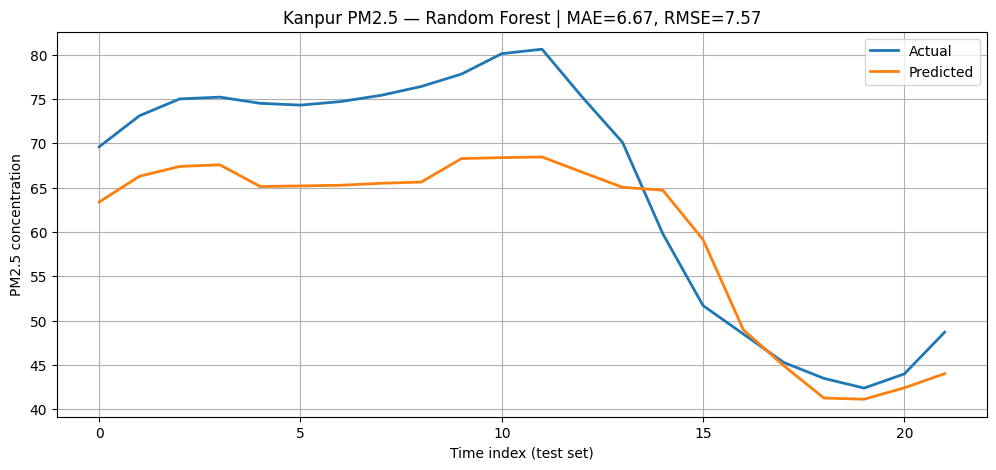

In [11]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linewidth=2)
plt.legend()
plt.title(f"Kanpur PM2.5 — Random Forest | MAE={mae_v:.2f}, RMSE={rmse_v:.2f}")
plt.xlabel("Time index (test set)")
plt.ylabel("PM2.5 concentration")
plt.grid(True)
plt.show()

Cell 9 — Save predictions

In [12]:
pred_df = pd.DataFrame({
    "datetime": df["datetime"].iloc[split_idx:].values,
    "PM2.5_actual": y_test.values,
    "PM2.5_predicted": y_pred
})
pred_df.to_csv("kanpur_predictions.csv", index=False)
print("📁 Saved kanpur_predictions.csv")

from google.colab import files
files.download("kanpur_predictions.csv")

📁 Saved kanpur_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>